# Tessellations network cleaning

This notebook tests a way to remove nodes that only connect two edges from the network (Nodes that connect two edges should not be intersections, should be continous lines).

__Result:__ Success!

## Import libraries

In [1]:
accesibilidad_urbana = "../../../"

In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

# Para obtener el punto central de una línea en los tests,
# Y para convertir MultiLineStrings a LineStrings.
from shapely.geometry import LineString, MultiLineString

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(accesibilidad_urbana))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Config notebook

In [3]:
input_path = accesibilidad_urbana + "data/external/volvo/input_tessellations_network/"
projection_crs = "EPSG:32618"

## Load data

In [4]:
# Simplified network (not functional)
#tessellations_nodes = gpd.read_file(input_path + "moravia_LH_tessellations_edited_nodes.shp")

# Non-simplified network
tessellations_nodes = gpd.read_file(input_path + "moravia_LH_tessellations_nodes_2.shp")

# Show
print(tessellations_nodes.shape)
tessellations_nodes.head(2)

(981, 2)


,osmid,geometry
0,0,POINT (-75.56603 6.26080)
1,1,POINT (-75.56558 6.26069)


In [5]:
# No duplicates in osmid check
print(tessellations_nodes.shape)
test = tessellations_nodes.copy()
test.drop_duplicates(subset='osmid',inplace=True)
print(test.shape)

(981, 2)
(981, 2)


In [6]:
# Simplified network (not functional)
#tessellations_edges = gpd.read_file(input_path + "moravia_LH_tessellations_edited_edges.shp")

# Non-simplified network
tessellations_edges = gpd.read_file(input_path + "moravia_LH_tessellations_edges_2.shp")

# Show
print(tessellations_edges.shape)
tessellations_edges.head(2)

(1604, 4)


,u,v,key,geometry
0,0,1,0,"LINESTRING (-75.56603 6.26080, -75.56603 6.260..."
1,0,3,0,"LINESTRING (-75.56603 6.26080, -75.56603 6.260..."


In [7]:
# No duplicates in u,v check
print(tessellations_edges.shape)
test = tessellations_edges.copy()
test.drop_duplicates(subset=['u','v'],inplace=True)
print(test.shape)

(1604, 4)
(1604, 4)


<Axes: >

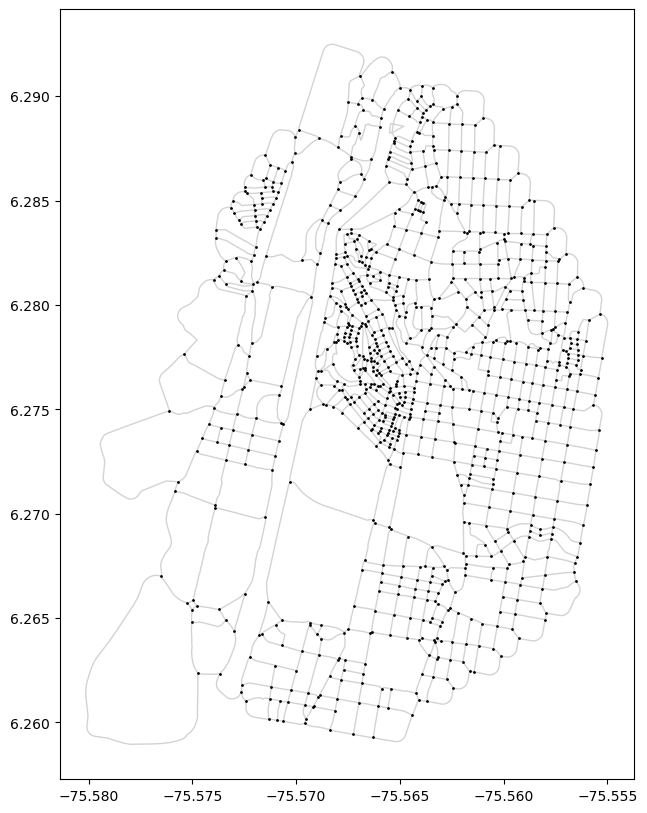

In [8]:
# Show plot
fig,ax = plt.subplots(1,1,figsize=(10,10))
tessellations_nodes.plot(ax=ax,zorder=1,color='black',markersize=1)
tessellations_edges.plot(ax=ax,zorder=0,color='lightgrey',linewidth=1)

## Exploring overlapping edges problem [Solved]

Overlapping was due to a previous tessellation simplification.

In [15]:
midpoints = tessellations_edges.copy()

# Find midpoint for each edge
def midpoint_of_linestring(line):
    if isinstance(line, LineString):
        midpoint = line.interpolate(0.5, normalized=True)
        return midpoint
    else:
        return None
midpoints['midpoint'] = midpoints['geometry'].apply(midpoint_of_linestring)
midpoints.drop(columns=['geometry'],inplace=True)
midpoints.rename(columns={'midpoint':'geometry'},inplace=True)
midpoints.set_geometry('geometry',inplace=True)

# Create a buffer around midpoints
midpoints = midpoints.to_crs(projection_crs)
midpoints_buffer = gpd.GeoDataFrame(geometry=midpoints.buffer(1))
midpoints_buffer = midpoints_buffer.to_crs("EPSG:4326")

# Find lines intersecting each buffer
midpoints_buffer = midpoints_buffer.reset_index()
midpoints_buffer.rename(columns={'index':'buffer_id'},inplace=True)
buffer_edges = gpd.sjoin(tessellations_edges,midpoints_buffer)
grouped_by = buffer_edges.groupby(['u','v']).count()

# Find overlapping edges
overlapping = grouped_by.loc[grouped_by.buffer_id>1]
overlapping = overlapping.reset_index()[['u','v']]

overlapping_buffers_ids = list(overlapping.merge(buffer_edges,on=['u','v']).buffer_id.unique())
overlapping_buffers = midpoints_buffer.loc[midpoints_buffer.buffer_id.isin(overlapping_buffers_ids)]

overlapping_buffers

,buffer_id,geometry


In [23]:
test_save = False

# Save to explore in QGIS
if test_save:
    overlapping_buffers.to_file(accesibilidad_urbana + "data/external/volvo/overlapping_2.gpkg")
    # Saved files:
    # Using simplified network --> 'overlapping' (Non-functional network)
    # Using network_2 (unsimplified) --> 'overlapping_2' (Functional network)

## Identify nodes used only by two edges 
##### (Those are not intersections, they should be a single line)

In [9]:
# ----- PART 1: IDENTIFY NODES THAT ARE USED BY ONLY TWO EDGES
u_list = list(tessellations_edges.u)
v_list = list(tessellations_edges.v)

# For each osmid, find the number of edges that reach that osmid.
for osmid in list(tessellations_nodes.osmid.unique()):
    
    streets_count = 0
    for u in u_list:
        if osmid == u:
            streets_count+=1
    for v in v_list:
        if osmid == v:
            streets_count+=1

    idx = tessellations_nodes.osmid == osmid
    tessellations_nodes.loc[idx,'streets_count'] = streets_count

# Osmids that only recieve two edges are not intersections, should be a continous line
two_edge_osmids = tessellations_nodes.loc[tessellations_nodes.streets_count==2].copy()

# ----- PART 2: REMOVE USELESS NODE, DISSOLVE LINES PREVIOUSLY USING THAT NODE.
fixed_nodes = tessellations_nodes.copy()
fixed_edges = tessellations_edges.copy()

for osmid in list(two_edge_osmids.osmid.unique()):
    print("--"*10)
    
    print(f"OSMID OF INTEREST: {osmid}.")
    
    # Find edges that use that osmid
    found_in_u = fixed_edges.loc[fixed_edges.u == osmid].copy()
    found_in_v = fixed_edges.loc[fixed_edges.v == osmid].copy()
    found_edges = pd.concat([found_in_u,found_in_v])
    print(found_edges)
    
    # Find the other osmids those edges connect with
    u_v_list = list(found_edges.u.unique()) + list(found_edges.v.unique())
    while osmid in u_v_list:
        u_v_list.remove(osmid)
    print(f"OSMIDS TO KEEP: {u_v_list}.")

    # Dissolve lines (Creates MultiLineString)
    flattened_edge = found_edges.dissolve()
    flattened_edge['u'] = u_v_list[0]
    flattened_edge['v'] = u_v_list[1]
    flattened_edge['key'] = 0

    # Delete useless node and previous edges, concat new flattened edge.
    fixed_nodes = fixed_nodes.loc[fixed_nodes.osmid != osmid].copy()
    fixed_edges = fixed_edges.loc[(fixed_edges.u != osmid)&(fixed_edges.v != osmid)].copy()
    fixed_edges = pd.concat([fixed_edges,flattened_edge])

# Final format
fixed_edges.reset_index(inplace=True)
fixed_edges.drop(columns=['index'],inplace=True)

# Final format
fixed_nodes.reset_index(inplace=True)
fixed_nodes.drop(columns=['index'],inplace=True)

# Show
print(fixed_edges.shape)
fixed_edges.tail(5)

--------------------
OSMID OF INTEREST: 516.
       u    v  key                                           geometry
806  513  516    0  LINESTRING (-75.56518 6.27610, -75.56518 6.276...
978  515  516    0  LINESTRING (-75.56512 6.27636, -75.56512 6.276...
OSMIDS TO KEEP: [513, 515].
--------------------
OSMID OF INTEREST: 515.
       u    v  key                                           geometry
979  515  517    0  LINESTRING (-75.56512 6.27636, -75.56512 6.276...
0    513  515    0  MULTILINESTRING ((-75.56518 6.27610, -75.56518...
OSMIDS TO KEEP: [513, 517].
--------------------
OSMID OF INTEREST: 788.
        u    v  key                                           geometry
1348  781  788    0  LINESTRING (-75.56395 6.28344, -75.56395 6.283...
1370  787  788    0  LINESTRING (-75.56387 6.28444, -75.56387 6.284...
OSMIDS TO KEEP: [781, 787].
(1601, 4)


,u,v,key,geometry
1596,965,966,0,"LINESTRING (-75.55910 6.28470, -75.55910 6.284..."
1597,965,972,0,"LINESTRING (-75.55910 6.28470, -75.55910 6.284..."
1598,982,980,0,"LINESTRING (-75.57148 6.28717, -75.57123 6.287..."
1599,513,517,0,"MULTILINESTRING ((-75.56512 6.27636, -75.56512..."
1600,781,787,0,"MULTILINESTRING ((-75.56395 6.28344, -75.56395..."


## Result evaluation

In [10]:
# ----- RE-IDENTIFY NODES THAT ARE USED BY ONLY TWO EDGES
u_list = list(fixed_edges.u)
v_list = list(fixed_edges.v)

# For each osmid, find the number of edges that reach that osmid.
for osmid in list(fixed_nodes.osmid.unique()):
    
    streets_count = 0
    for u in u_list:
        if osmid == u:
            streets_count+=1
    for v in v_list:
        if osmid == v:
            streets_count+=1

    idx = fixed_nodes.osmid == osmid
    fixed_nodes.loc[idx,'streets_count'] = streets_count

# Osmids that only recieve two edges are not intersections, should be a continous line
two_edge_osmids = fixed_nodes.loc[fixed_nodes.streets_count==2].copy()
two_edge_osmids

,osmid,geometry,streets_count


<Axes: >

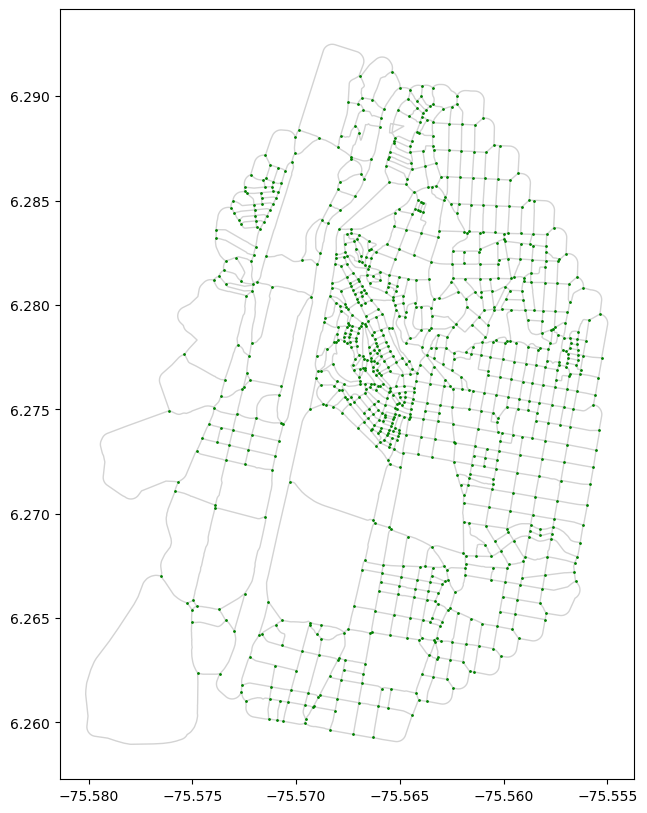

In [11]:
# Show plot
fig,ax = plt.subplots(1,1,figsize=(10,10))
fixed_nodes.plot(ax=ax,zorder=1,color='green',markersize=1)
fixed_edges.plot(ax=ax,zorder=0,color='lightgrey',linewidth=1)

In [15]:
output_save = False

# Save to explore in QGIS
if output_save:
    fixed_nodes.to_file(accesibilidad_urbana + "data/external/volvo/output_tessellations_network/moravia_LH_tesselations_nodes_f.gpkg")
    fixed_edges.to_file(accesibilidad_urbana + "data/external/volvo/output_tessellations_network/moravia_LH_tesselations_edges_f.gpkg")